In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re
from scipy.stats import norm

In [2]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/labels.parquet'
OUTPUT_PATH = '/Users/maedeh/Desktop/demand_project/shoofer-demand-prediction/data/arima_predict.parquet'

In [3]:
def load_data(path):
    dataset = pd.read_parquet(path, engine = 'pyarrow')
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH)
rides_df.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [5]:
def concat_actual_predict(rides_df):
    rides_df.columns=['Location','Data','Actual demand']
    rides_df['Predict demand'] = rides_df['Actual demand'].shift(1)
    rides_df.dropna(inplace = True)
    return rides_df

In [6]:
rides_df = concat_actual_predict(rides_df)
rides_df.head()

,Location,Data,Actual demand,Predict demand
1,1,2023-01-02,31.0,40.0
2,1,2023-01-03,27.0,31.0
3,1,2023-01-04,7.0,27.0
4,1,2023-01-05,15.0,7.0
5,1,2023-01-06,11.0,15.0


In [7]:
def high_demand_index(rides_df):
    high_demand = pd.DataFrame(rides_df.groupby(rides_df['Location'])['Actual demand'].sum().sort_values(ascending=False)[:49])
    ind_high_demand = high_demand.index
    return ind_high_demand

In [10]:
def plot_hist(rides_df, bin):
    
    ind_high_demand = high_demand_index(rides_df)
    plt.rcParams['figure.figsize'] = (40, 70)
    
    for i,loc in enumerate(ind_high_demand):
        
        plt.subplot(17,3,i+1)

        error = rides_df[rides_df.Location==loc]['Actual demand'] - rides_df[rides_df.Location==loc]['Predict demand']
        under_estimate_percentage = error[error>0].count()*100/len(error)
        over_estimate_percentage = error[error<0].count()*100/len(error) 
        
        sb.histplot(error, kde=True, bins=bin, label=f'Histogram and Estimated density of Error for Location{loc}', color='green')
    
        mu=0
        sigma=np.std(error)    
        x = np.linspace(np.min(error), np.max(error), 100)
        y = norm.pdf(x, mu, sigma)
        kde_max = np.max(sb.histplot(error, kde=True, bins=bin).get_lines()[0].get_data()[1])
        y *= kde_max / np.max(y)
        
        plt.plot(x, y, 'r-', label='Normal Gaussian Distribution')
        plt.ylabel('Count', fontsize=25)
        plt.xlabel('Error', fontsize=20)
        plt.tick_params(axis='both', labelsize=13)
        plt.legend(fontsize='17')
        plt.title(f'percentage of underestimate: {under_estimate_percentage:.1f}\npercentage of overestimate: {over_estimate_percentage:.1f}', fontsize=25)
    plt.tight_layout()
    plt.show()

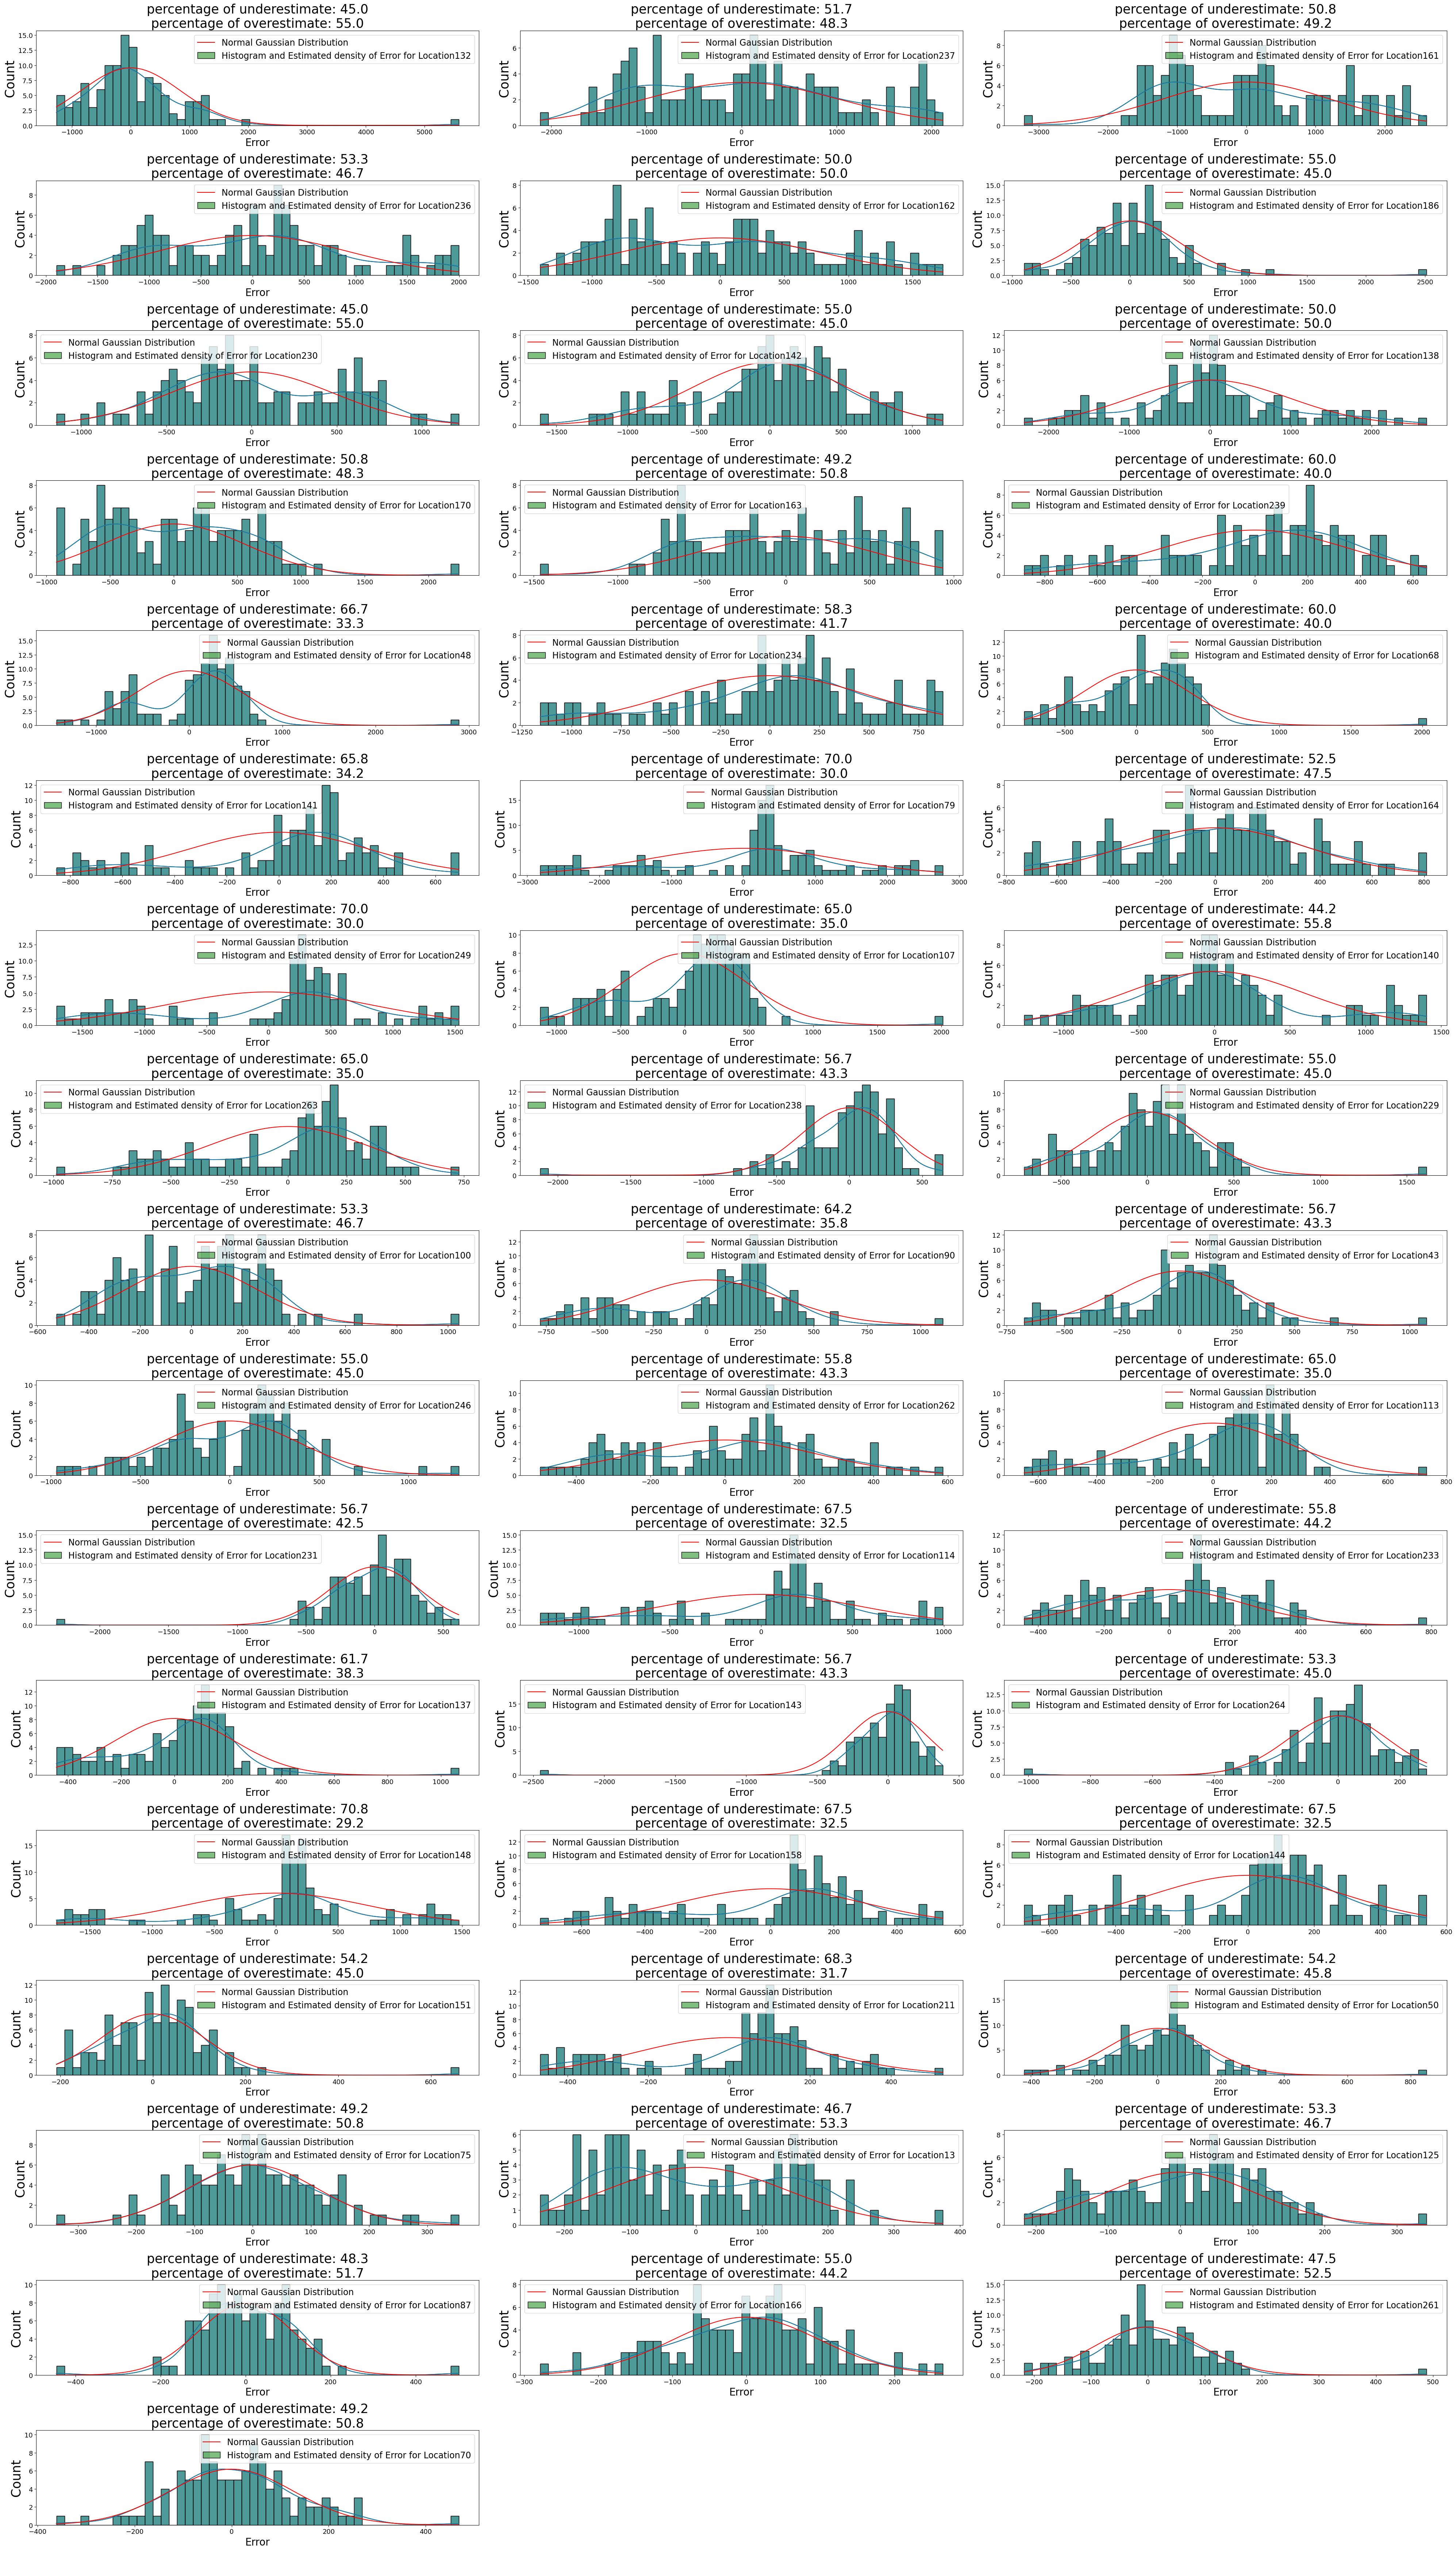

In [11]:
plot_hist(rides_df, bin = 50)